In [ ]:
# Import Libraries 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Sentiment Analysis

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from textblob import TextBlob
from nltk.util import ngrams
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving hashtag_donaldtrump.csv to hashtag_donaldtrump.csv
Saving hashtag_joebiden.csv to hashtag_joebiden.csv


In [ ]:
# Read Data sets into the notebook
trump_df = pd.read_csv(r"hashtag_donaldtrump.csv",lineterminator='\n')

biden_df = pd.read_csv(r"hashtag_joebiden.csv",lineterminator='\n')

In [ ]:
# Check shape of both data frames

print(trump_df.shape)

print(biden_df.shape)

(2000, 21)
(2000, 21)


In [ ]:
# Check Info of both data sets 
print(trump_df.info())

print(biden_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   created_at            2000 non-null   object 
 1   tweet_id              2000 non-null   float64
 2   tweet                 2000 non-null   object 
 3   likes                 2000 non-null   float64
 4   retweet_count         2000 non-null   float64
 5   source                1995 non-null   object 
 6   user_id               2000 non-null   float64
 7   user_name             2000 non-null   object 
 8   user_screen_name      2000 non-null   object 
 9   user_description      1770 non-null   object 
 10  user_join_date        2000 non-null   object 
 11  user_followers_count  2000 non-null   float64
 12  user_location         1386 non-null   object 
 13  lat                   1064 non-null   float64
 14  long                  1064 non-null   float64
 15  city                 

In [ ]:
# Adding a new column to differentiate between tweets of Biden and Trump
trump_df["Class"] = "TRUMP"
biden_df["Class"] = "BIDEN"

In [ ]:
# Concat the data frames(iki veriyi birlestirip,created at'e gore siraliyor)
Data_Mixed = pd.concat([trump_df,biden_df])
Data_Mixed.sort_values(by='created_at') # overt to datetime format
#df["created_at"] = pd.to_datetime(df.created_at) 
Data_Mixed.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,Class
0,2020-10-15 00:00:01,1316529221557252096.0,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,TRUMP
1,2020-10-15 00:00:01,1316529222748430336.0,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,TRUMP
2,2020-10-15 00:00:02,1316529228091846912.0,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,TRUMP
3,2020-10-15 00:00:02,1316529227471237120.0,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,TRUMP
4,2020-10-15 00:00:08,1316529252301451264.0,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,TRUMP


**CLEAN DATA** 

In [ ]:
#check for duplicates
print("Count of duplicates: {}".format(Data_Mixed.duplicated(subset=["tweet"]).sum()))

Count of duplicates: 321


In [ ]:
# Dropping all duplicates
print("Original size of Data_Mixed: {}".format(len(Data_Mixed)))
Data_Mixed.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print("No duplicates size of Data_Mixed : {}".format(len(Data_Mixed)))

Original size of Data_Mixed: 4000
No duplicates size of Data_Mixed : 3362


In [ ]:
def clean(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    return text

In [ ]:
Data_Mixed['tweet']= Data_Mixed['tweet'].apply(lambda x: clean(x))

In [ ]:
Data_Mixed.head(10)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,Class
1,2020-10-15 00:00:01,1316529222748430336.0,usa trump contro facebook e twitter coprono...,26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,TRUMP
2,2020-10-15 00:00:02,1316529228091846912.0,trump as a student i used to hear for years ...,2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,TRUMP
3,2020-10-15 00:00:02,1316529227471237120.0,hours since last tweet from trump maybe he i...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,TRUMP
4,2020-10-15 00:00:08,1316529252301451264.0,you get a tie and you get a tie trump s ral...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,TRUMP
5,2020-10-15 00:00:17,1316529291052675072.0,her minutes were over long time ago omaros...,2.0,0.0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,#BidenHarris2020 #JoeBiden2020 #KamalaHarrisFo...,...,"Perris,California",33.782519,-117.228648,NaN,United States of America,North America,California,CA,2020-10-21 00:00:01.866082651,TRUMP
6,2020-10-15 00:00:17,1316529289949569024.0,glad u got out of the house dick trump,0.0,0.0,Twitter for iPhone,7.674018e+17,Michael Wilson,wilsonfire9,NaN,...,"Powell, TN",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:02.239299182,TRUMP
7,2020-10-15 00:00:18,1316529293497962496.0,there won t be many of them unless you al...,0.0,0.0,Twitter for iPhone,9.007611e+17,Stacey Gulledge 🇺🇸 Patriot ♥️ KAG 🙏 👮‍♀️♥️,sm_gulledge,"Patriot, Wife, “Shaken not Stirred” Mom of two...",...,"Ohio, USA",40.225357,-82.688140,NaN,United States of America,North America,Ohio,OH,2020-10-21 00:00:02.612515712,TRUMP
8,2020-10-15 00:00:20,1316529301332918272.0,one of the single most effective remedies to e...,0.0,0.0,Twitter Web App,5.404769e+08,Jamieo,jamieo33,"Don't know what I am. Can lean left and right,...",...,"Pennsylvania, USA",40.969989,-77.727883,NaN,United States of America,North America,Pennsylvania,PA,2020-10-21 00:00:02.985732243,TRUMP
9,2020-10-15 00:00:21,1316529308576309248.0,trump freedomofspeech,0.0,0.0,Twitter Web App,1.305533e+18,Johnny Quest,JohnnyQuest22,Independent\n\nWhat is your American Dream?\nT...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:03.358948773,TRUMP
12,2020-10-15 00:00:26,1316529328608481280.0,trump presidenttrump maga kag america ameri...,3.0,5.0,Twitter for Android,1.243315e+18,Ron Burgundy,Anchorman_USA,"I'm kind of a Big Deal, People know me! I driv...",...,"San Diego, CA",32.717421,-117.162771,San Diego,United States of America,North America,California,CA,2020-10-21 00:00:04.478598364,TRUMP


**OUR ANALYSIS**

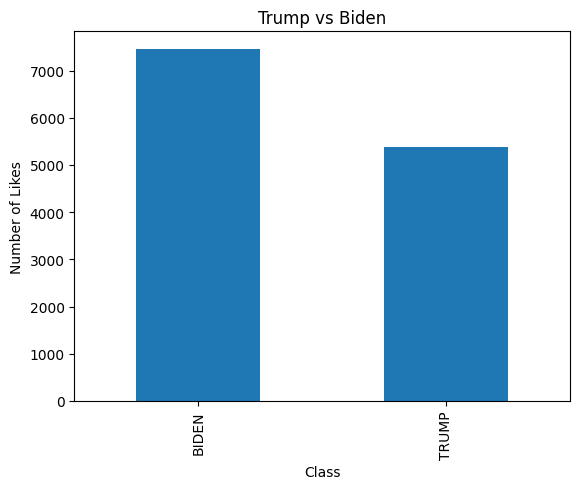

In [ ]:
# Comparison of likes
Data_Mixed.groupby('Class')['likes'].sum().plot.bar()
plt.ylabel('Number of Likes')
plt.title('Trump vs Biden')
plt.show()

**-When we look at the graph above, we see that the number of likes for tweets about Biden is higher. This shows that Biden is talked about more than Trump.**

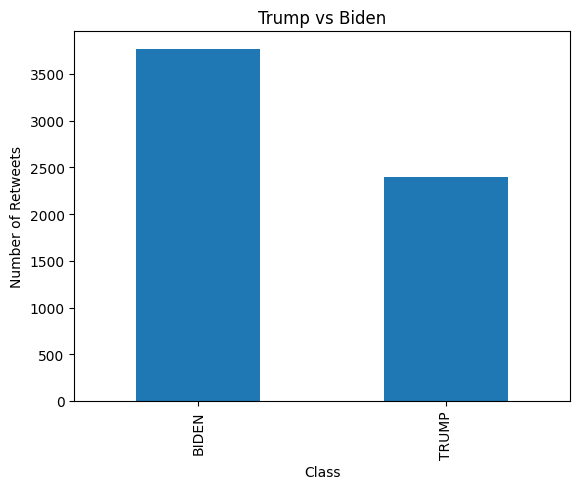

In [ ]:
# Comparison of retweets
Data_Mixed.groupby('Class')['retweet_count'].sum().plot.bar()
plt.ylabel('Number of Retweets')
plt.title('Trump vs Biden')
plt.show()

**-When we compare the tweets according to the number of retweets this time, we can say that the tweets about Biden are retweeted more and reach more people**

In [ ]:
Data_Mixed.country.value_counts()

United States of America    1148
United States                192
Canada                        81
United Kingdom                59
Australia                     39
                            ... 
Portugal                       1
Finland                        1
Cameroon                       1
Barbados                       1
Iraq                           1
Name: country, Length: 68, dtype: int64

In [ ]:
Data_Mixed['country']=Data_Mixed['country'].replace({"United States of America" : "US", "United States" : "US"})

In [ ]:
Data_Mixed.country.value_counts()

US                1340
Canada              81
United Kingdom      59
Australia           39
France              21
                  ... 
Portugal             1
Finland              1
Cameroon             1
Barbados             1
Iraq                 1
Name: country, Length: 67, dtype: int64

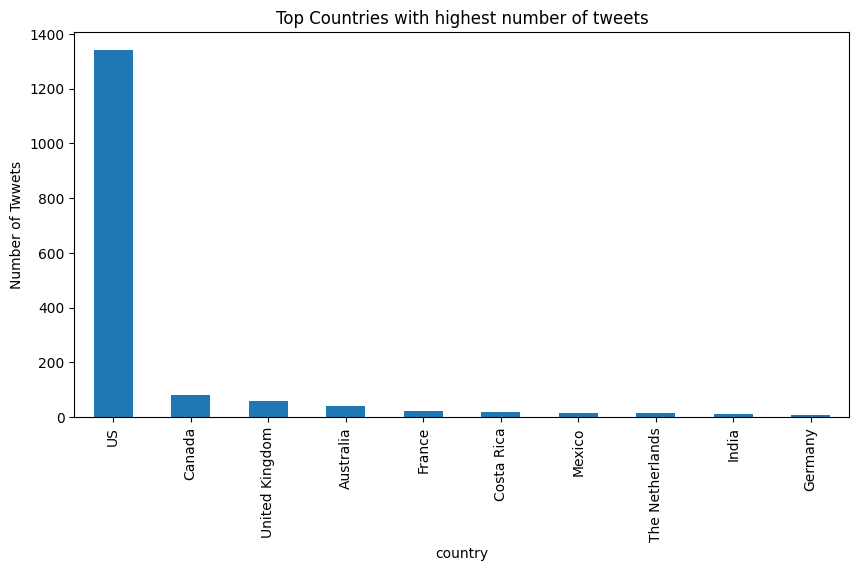

In [ ]:
# Countries with highest number of tweets
plt.figure(figsize=(10,5))
Data_Mixed.groupby('country')['tweet'].count().sort_values(ascending=False).head(10).plot.bar()
plt.ylabel('Number of Twwets')
plt.title('Top Countries with highest number of tweets')
plt.show()

**-As expected more Tweets are from US, as elections are being conducted there**

In [ ]:
# List of top 10 countries with highest number of tweets
top10Countries = Data_Mixed.groupby('country')['tweet'].count().sort_values(ascending=False).head(10).index.tolist()

In [ ]:
# Twwets for Biden and Trump from each country
tweet_df = Data_Mixed.groupby(['country','Class'])['tweet'].count().reset_index()

tweet_df = tweet_df[tweet_df['country'].isin(top10Countries)]

tweet_df

,country,Class,tweet
3,Australia,BIDEN,10
4,Australia,TRUMP,29
11,Canada,BIDEN,34
12,Canada,TRUMP,47
18,Costa Rica,BIDEN,1
19,Costa Rica,TRUMP,18
28,France,BIDEN,1
29,France,TRUMP,20
32,Germany,BIDEN,1
33,Germany,TRUMP,8


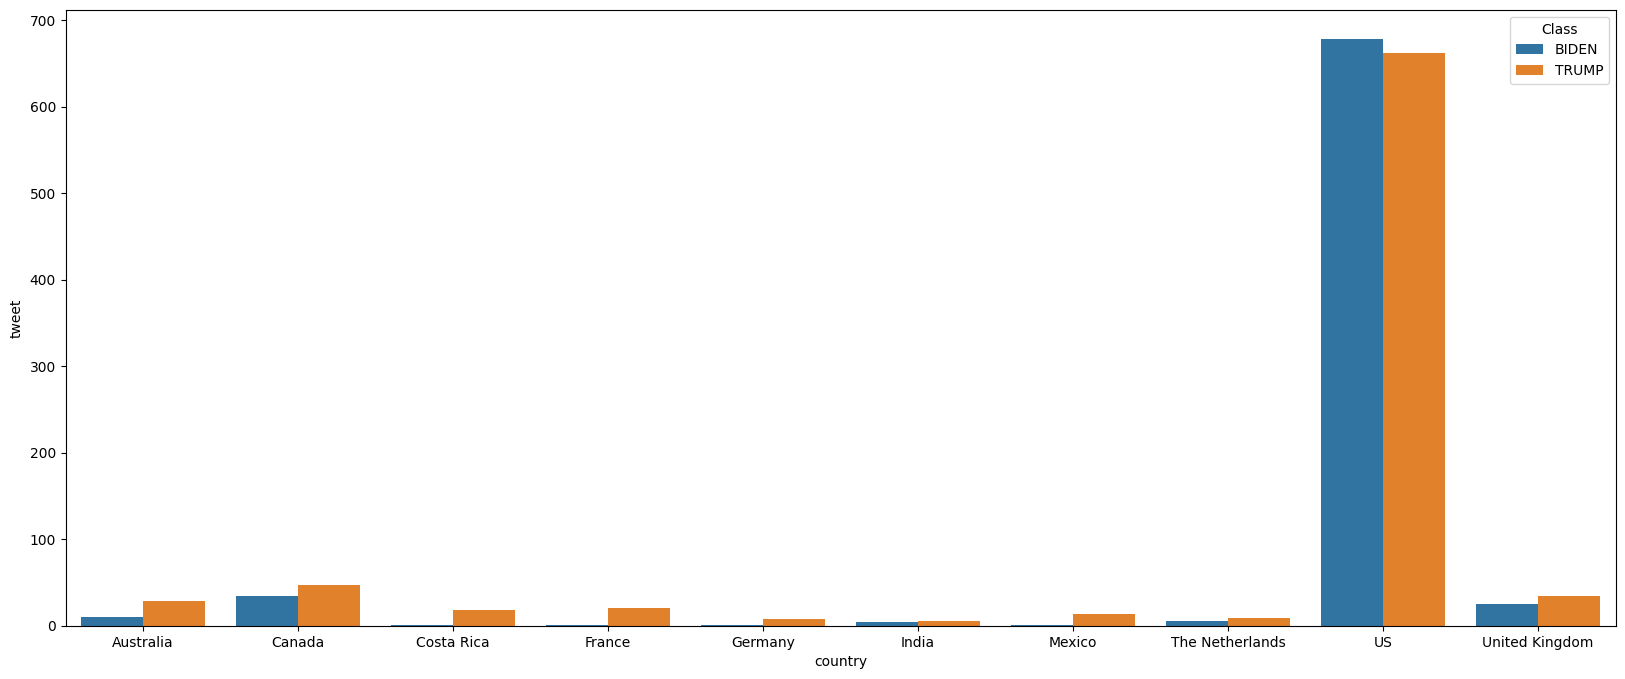

In [ ]:
#Plot top 10 countries with highest number of tweets for trump and biden
plt.figure(figsize=(20,8))
sns.barplot(data=tweet_df,x='country',y='tweet',hue='Class')
plt.show()

**-Except in US Most of countries tweets more about Trump**

<Axes: title={'center': "tweet count in country 'France'"}, ylabel='tweet'>

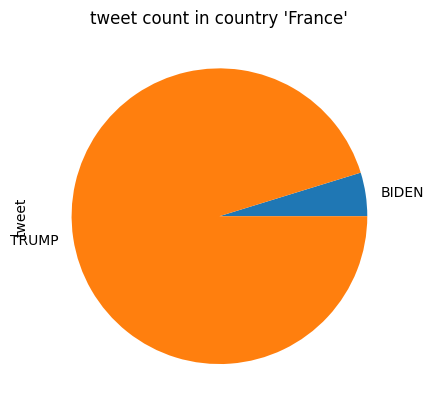

In [ ]:
country="France"
a=Data_Mixed[Data_Mixed.country==country].groupby('Class').tweet.count()
a.plot(x='Class', y="tweet", kind="pie", title = "tweet count in country 'France'")

<Axes: title={'center': "tweet count in country 'US'"}, ylabel='tweet'>

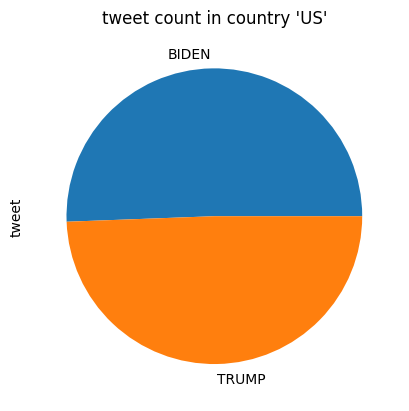

In [ ]:
country="US"
a=Data_Mixed[Data_Mixed.country==country].groupby('Class').tweet.count()
a.plot(x='Class', y="tweet", kind="pie", title = "tweet count in country 'US'")

In [ ]:
# List of top 10 states with highest number of tweets
top10States = Data_Mixed.groupby('state')['tweet'].count().sort_values(ascending=False).head(10).index.tolist()

In [ ]:
# Twets for Biden and Trump from each state in top10 states
state_df = Data_Mixed.groupby(['state','Class'])['tweet'].count().reset_index()

state_df = state_df[state_df['state'].isin(top10States)]

state_df

,state,Class,tweet
22,California,BIDEN,80
23,California,TRUMP,91
42,England,BIDEN,19
43,England,TRUMP,21
44,Florida,BIDEN,44
45,Florida,TRUMP,60
57,Illinois,BIDEN,20
58,Illinois,TRUMP,27
98,New Jersey,BIDEN,31
99,New Jersey,TRUMP,21


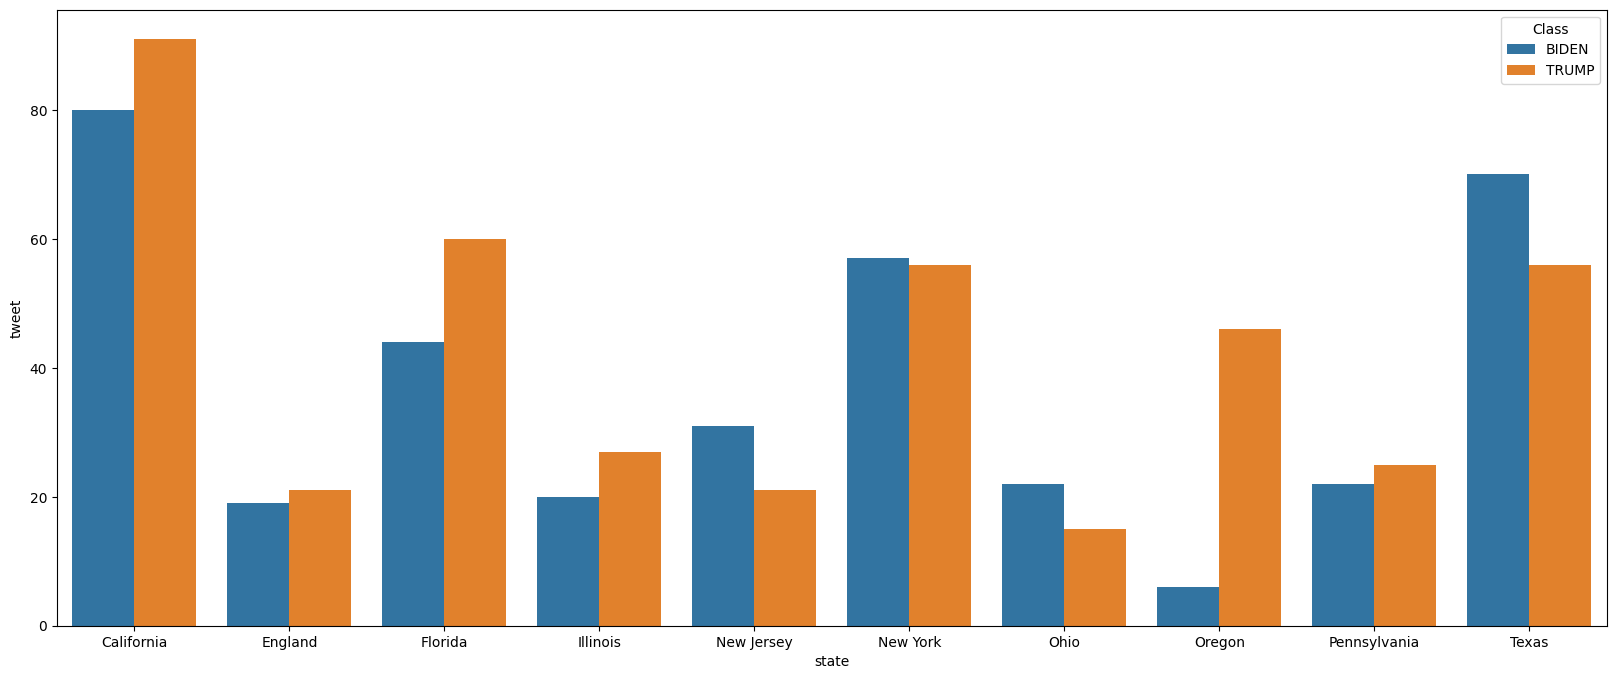

In [ ]:
#Plot top 10 states with highest number of tweets for trump and biden
plt.figure(figsize=(20,8))
sns.barplot(data=state_df,x='state',y='tweet',hue='Class')
plt.show()

**-When analysing the top 10 states, we see that the tweets are more for Trump than Biden.**

<Axes: title={'center': "tweet count in state 'Texas'"}, ylabel='tweet'>

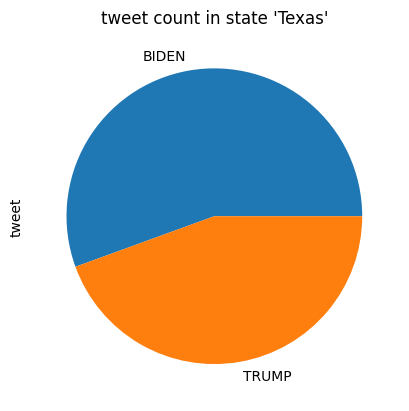

In [ ]:
state="Texas"
a=Data_Mixed[Data_Mixed.state==state].groupby('Class').tweet.count()
a.plot(x='Class', y="tweet", kind="pie", title = "tweet count in state 'Texas'")

<Axes: title={'center': "tweet count in state 'Oregon'"}, ylabel='tweet'>

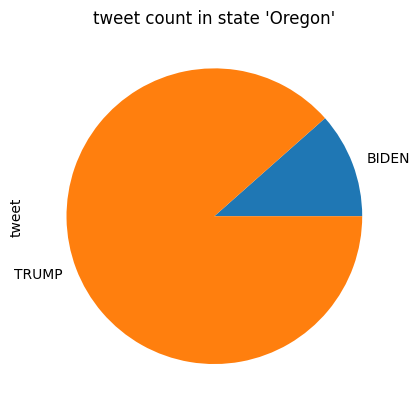

In [ ]:
state="Oregon"
a=Data_Mixed[Data_Mixed.state==state].groupby('Class').tweet.count()
a.plot(x='Class', y="tweet", kind="pie", title = "tweet count in state 'Oregon'")

In [ ]:
# List of top 10 cities with highest number of tweets
top10Cities = Data_Mixed.groupby('city')['tweet'].count().sort_values(ascending=False).head(10).index.tolist()

In [ ]:
# Twets for Biden and Trump from each city in top10 cities
city_df = Data_Mixed.groupby(['city','Class'])['tweet'].count().reset_index()

city_df = city_df[city_df['city'].isin(top10Cities)]

city_df

,city,Class,tweet
9,Atlanta,BIDEN,10
10,Atlanta,TRUMP,12
11,Atlantic City,BIDEN,17
41,Chicago,BIDEN,10
42,Chicago,TRUMP,18
90,Houston,BIDEN,11
91,Houston,TRUMP,11
115,Los Angeles,BIDEN,22
116,Los Angeles,TRUMP,28
147,New York,BIDEN,46


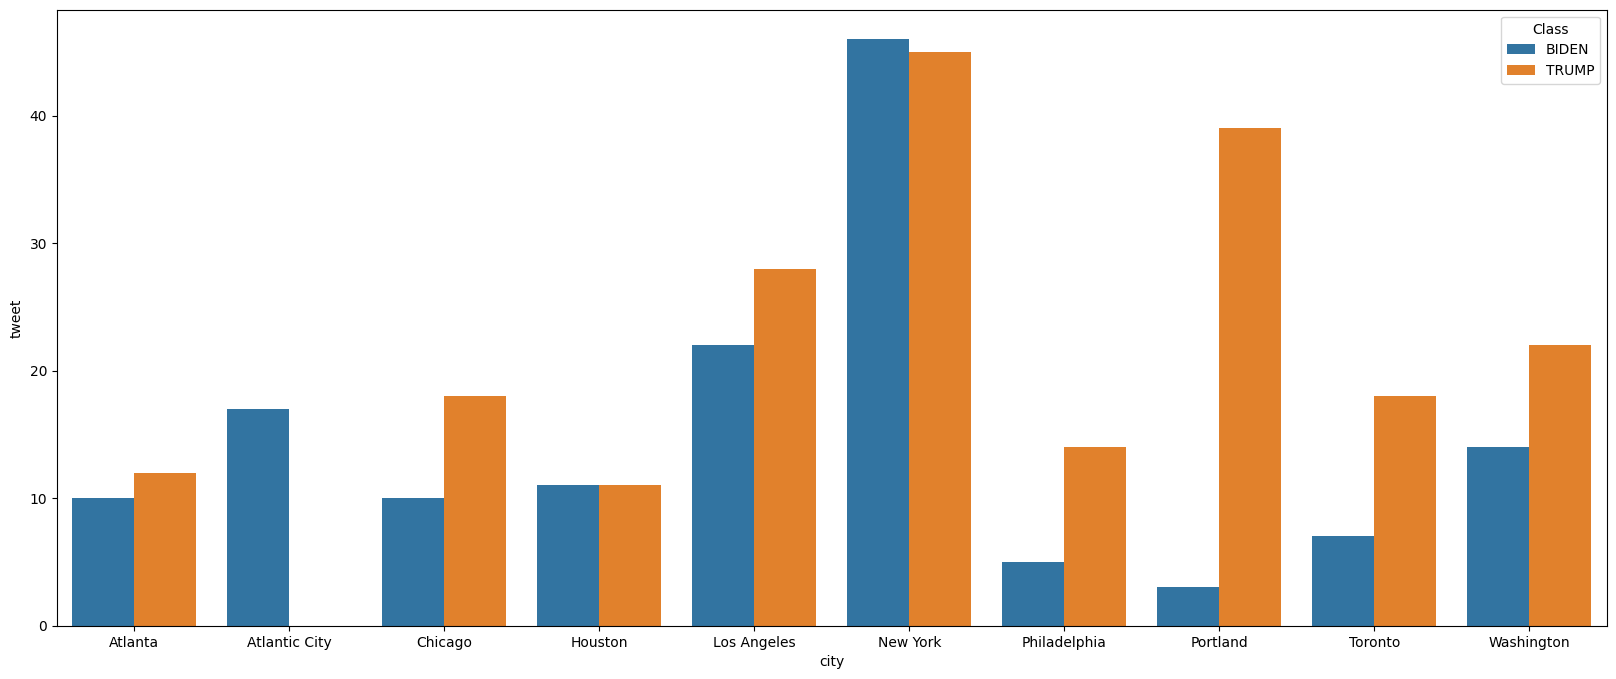

In [ ]:
#Plot top 10 cities with highest number of tweets for trump and biden
plt.figure(figsize=(20,8))
sns.barplot(data=city_df,x='city',y='tweet',hue='Class')
plt.show()

In [ ]:
# List of top 5 continents with highest number of tweets
top5continents = Data_Mixed.groupby('continent')['tweet'].count().sort_values(ascending=False).head(5).index.tolist()

In [ ]:
# Twets for Biden and Trump from each continents in top5 continents
continent_df = Data_Mixed.groupby(['continent','Class'])['tweet'].count().reset_index()

continent_df = continent_df[continent_df['continent'].isin(top5continents)]

continent_df

,continent,Class,tweet
2,Asia,BIDEN,37
3,Asia,TRUMP,33
4,Europe,BIDEN,48
5,Europe,TRUMP,91
6,North America,BIDEN,717
7,North America,TRUMP,745
8,Oceania,BIDEN,14
9,Oceania,TRUMP,33
10,South America,BIDEN,6
11,South America,TRUMP,17


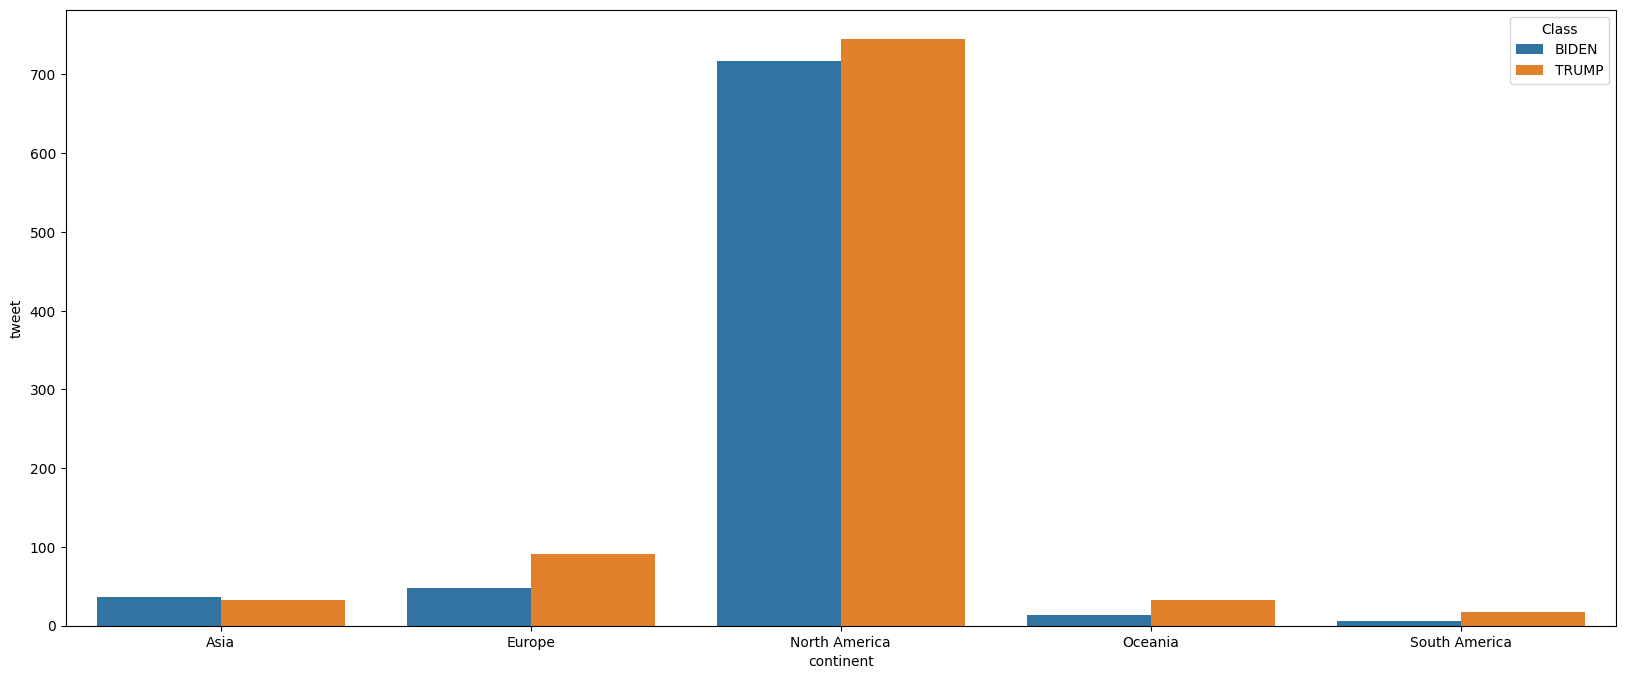

In [ ]:
#Plot top 5 continents with highest number of tweets for trump and biden
plt.figure(figsize=(20,8))
sns.barplot(data=continent_df,x='continent',y='tweet',hue='Class')
plt.show()

**-As expected, more elections were discussed in North America.**

In [ ]:
top_10_trump_followers = Data_Mixed[Data_Mixed["Class"] == "TRUMP"]\
    .sort_values(by="user_followers_count", ascending=False)\
    .head(10)[["user_name", "user_followers_count"]]

for index, row in top_10_trump_followers.iterrows():
    user_name = row["user_name"]
    follower_count = row["user_followers_count"]
    print(f"User Name: {user_name} - Follower Count: {follower_count}")

User Name: detikcom - Follower Count: 16226346.0
User Name: Hindustan Times - Follower Count: 7795008.0
User Name: Teleamazonas - Follower Count: 2210106.0
User Name: DNA - Follower Count: 2199477.0
User Name: Tgcom24 - Follower Count: 1067661.0
User Name: Noticias Telemundo - Follower Count: 812382.0
User Name: New Straits Times - Follower Count: 725476.0
User Name: El Economista - Follower Count: 633734.0
User Name: Revista Vistazo - Follower Count: 470694.0
User Name: Diario Tiempo, HN - Follower Count: 266146.0


In [ ]:
Data_Mixed["user_followers_count"].fillna(0, inplace=True)

In [ ]:
for column in Data_Mixed.columns:
    # Eksik değer sayısını kontrol etme
    missing_values = Data_Mixed[column].isnull().sum()

    if missing_values > 0:
        print(f"Sütun: {column}")
        print(f"Eksik Değer Sayısı: {missing_values}")

Sütun: tweet_id
Eksik Değer Sayısı: 1
Sütun: likes
Eksik Değer Sayısı: 2
Sütun: retweet_count
Eksik Değer Sayısı: 2
Sütun: source
Eksik Değer Sayısı: 2
Sütun: user_id
Eksik Değer Sayısı: 2
Sütun: user_name
Eksik Değer Sayısı: 2
Sütun: user_screen_name
Eksik Değer Sayısı: 2
Sütun: user_description
Eksik Değer Sayısı: 463
Sütun: user_join_date
Eksik Değer Sayısı: 3
Sütun: user_location
Eksik Değer Sayısı: 1113
Sütun: lat
Eksik Değer Sayısı: 1611
Sütun: long
Eksik Değer Sayısı: 1611
Sütun: city
Eksik Değer Sayısı: 2536
Sütun: country
Eksik Değer Sayısı: 1612
Sütun: continent
Eksik Değer Sayısı: 1612
Sütun: state
Eksik Değer Sayısı: 1973
Sütun: state_code
Eksik Değer Sayısı: 2022
Sütun: collected_at
Eksik Değer Sayısı: 3


In [ ]:
#biden icin user_followers_count objectti, o yüzden bu degiskenin tipini numeric yaptik
Data_Mixed["user_followers_count"] = pd.to_numeric(Data_Mixed["user_followers_count"], errors="coerce")

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 127474 (\N{REGIONAL INDICATOR SYMBOL LETTER M}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR

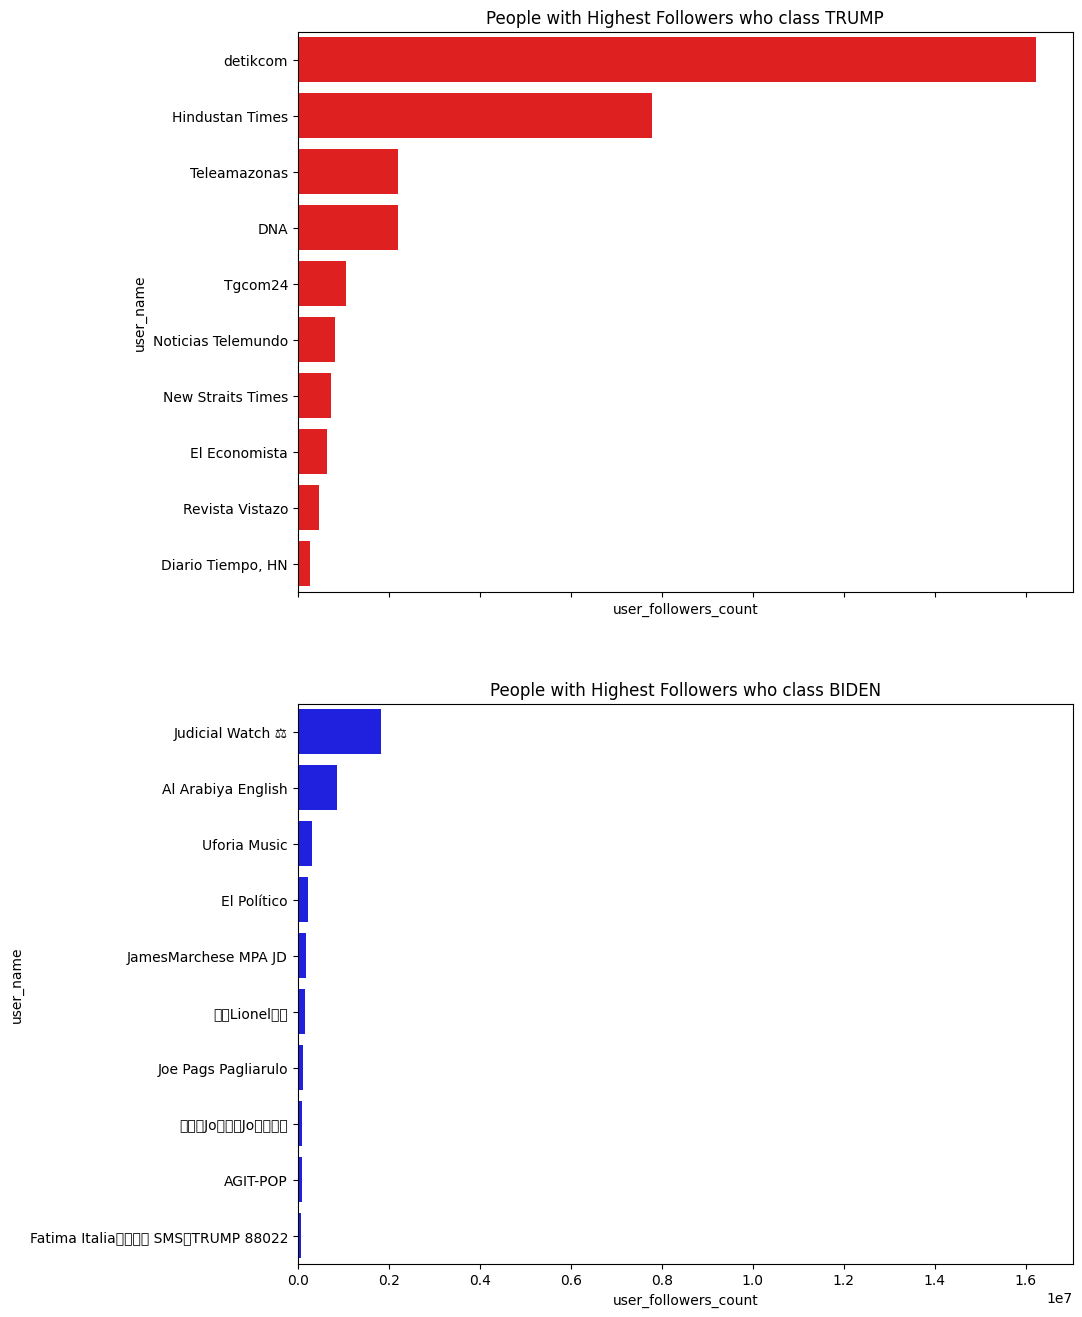

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 16), sharex=True)
sns.barplot(x="user_followers_count", y="user_name", orient="h", ax=ax1, palette=["r"],
           data=Data_Mixed[(Data_Mixed.Class == "TRUMP")]\
           .drop_duplicates(subset=["user_name"])\
           .sort_values(by=["user_followers_count"], ascending=False)[["user_name", "user_followers_count"]][:10])
ax1.set_title('People with Highest Followers who class TRUMP')

sns.barplot(x="user_followers_count", y="user_name", orient="h", ax=ax2, palette=["b"],
           data=Data_Mixed[(Data_Mixed.Class == "BIDEN")]
           .drop_duplicates(subset=["user_name"])\
           .sort_values(by=["user_followers_count"], ascending=False)[["user_name", "user_followers_count"]][:10])
ax2.set_title('People with Highest Followers who class BIDEN')
fig.show()

**Data Training**

-----Naive Bayes-----

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


X = Data_Mixed["tweet"]
y = Data_Mixed["Class"]



vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)



X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)


nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


y_pred = nb_model.predict(X_test)

nb_accuracy = (y_pred == y_test).mean()
print("Accuracy:", nb_accuracy)

Accuracy: 0.937592867756315


**Here, we train the Naive Bayes classification model. After making predictions on the test set, we calculate the accuracy rate. According to our calculations, Accuracy: 0.93759, which shows that our model has a correct prediction rate of 93%.**

----- KNN Algorithm -----

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


X2 = Data_Mixed["tweet"]
y2 = Data_Mixed["Class"]


vectorizer = CountVectorizer()
X_vectorized2 = vectorizer.fit_transform(X)


X_train2, X_test2, y_train2, y_test2 = train_test_split(X_vectorized2, y2, test_size=0.2, random_state=42)


knn_model = KNeighborsClassifier()
knn_model.fit(X_train2, y_train2)


y_pred2 = knn_model.predict(X_test2)

knn_accuracy = (y_pred2 == y_test2).mean()
print("Accuracy:", knn_accuracy)

Accuracy: 0.9435364041604755


**-Here, we train the K-nn classification model. After predicting on the test set, we calculate the accuracy rate. According to our calculations, Accuracy: 0.94353, which shows that the correct prediction rate of our model is 94%.**

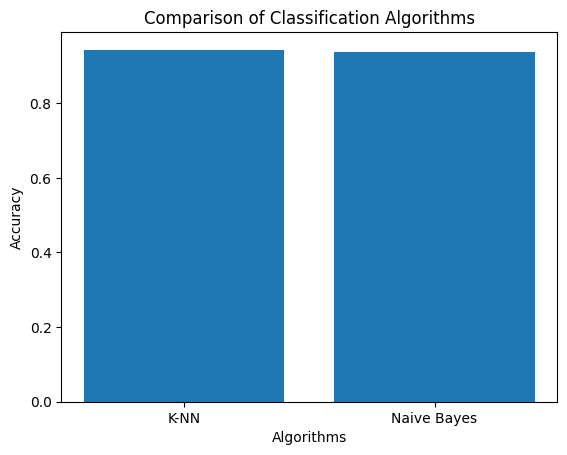

In [ ]:
#COMPARISON
algorithms = ["K-NN", "Naive Bayes"]
accuracies = [knn_accuracy, nb_accuracy]
plt.bar(algorithms, accuracies)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
plt.title("Comparison of Classification Algorithms")
plt.show()

**-When we compare the two algorithms, we see that although the accuracy rate of both algorithms is very close, numerically, the data set trained with the k-nn algorithm is more accurate.**

<ipython-input-225-225af47d8379>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=Data_Mixed[Data_Mixed.user_followers_count < Data_Mixed.user_followers_count.quantile(.999)].drop_duplicates(subset=["user_id"]), palette=["r", "b"],


Text(0.5, 1.0, 'User Follower counts')

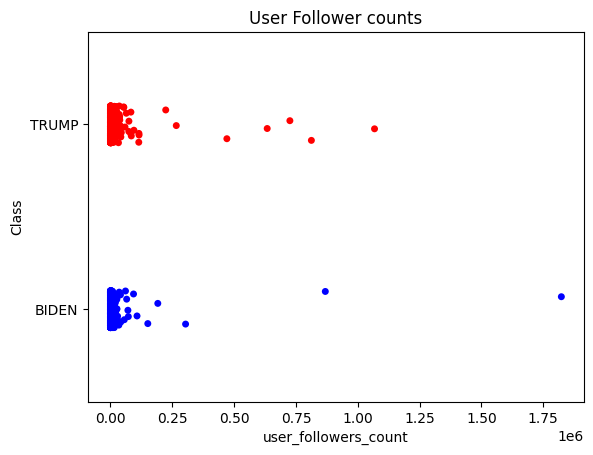

In [ ]:
ax = sns.stripplot(data=Data_Mixed[Data_Mixed.user_followers_count < Data_Mixed.user_followers_count.quantile(.999)].drop_duplicates(subset=["user_id"]), palette=["r", "b"],
                  x="user_followers_count",
                  y="Class")
ax.set_title("User Follower counts")

**-When we compare the tweet densities according to the number of user follower count, the account with the highest number of followers tweeting about Biden has 1.7k followers, while this number is 1.0k for the Trump. Accordingly, the tweet about Biden is expected to create more echo.**

<ipython-input-226-c937f125e645>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=Data_Mixed[Data_Mixed.retweet_count < Data_Mixed.retweet_count.quantile(.999)].drop_duplicates(subset=["user_id"]), palette=["r", "b"],


Text(0.5, 1.0, 'Retweet counts')

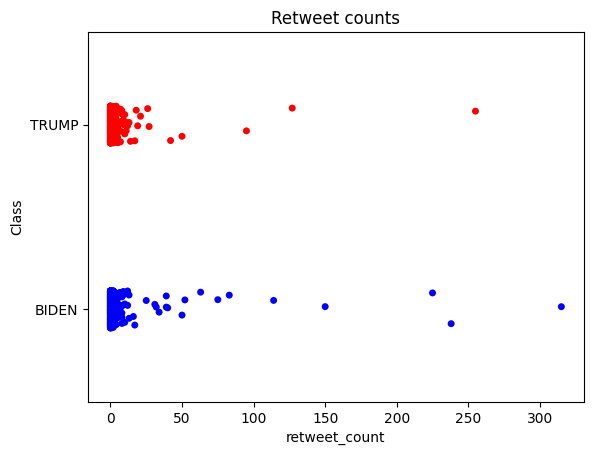

In [ ]:
ax = sns.stripplot(data=Data_Mixed[Data_Mixed.retweet_count < Data_Mixed.retweet_count.quantile(.999)].drop_duplicates(subset=["user_id"]), palette=["r", "b"],
                  x="retweet_count",
                  y="Class")
ax.set_title("Retweet counts")

**-When we compare the tweet densities according to the number of retweets, the highest number of retweets received by the tweet about biden is more than 300, while this number is 250 for trump. Accordingly, the tweet about Biden is expected to create more echo.**

<ipython-input-227-a71e641ad744>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax= sns.stripplot(data=Data_Mixed[Data_Mixed.likes < Data_Mixed.likes.quantile(.999)].drop_duplicates(subset=["user_id"]), palette=["r", "b"],


Text(0.5, 1.0, 'Likes count')

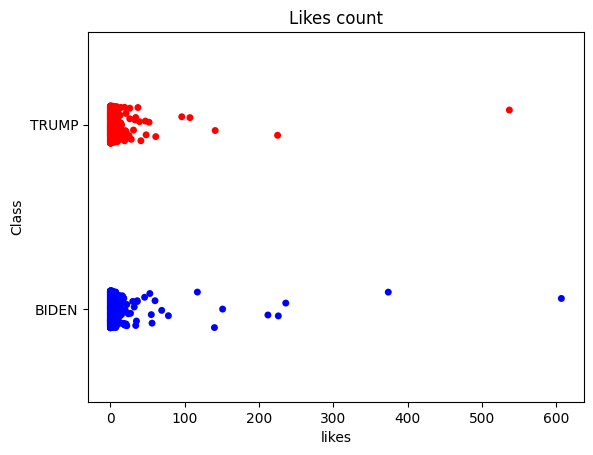

In [ ]:
ax= sns.stripplot(data=Data_Mixed[Data_Mixed.likes < Data_Mixed.likes.quantile(.999)].drop_duplicates(subset=["user_id"]), palette=["r", "b"],
                 x="likes",
                 y="Class")
ax.set_title("Likes count")

**-When we compare the tweet densities according to the number of likes, the highest number of likes received by the tweet about biden is around 600, while this number is around 500 for trump. Accordingly, the tweet about biden is expected to create more echo.**

In [ ]:
def clean(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    return text

In [ ]:
# create fuction to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score==0:
        return 'neutral'
    else:
        return 'positive'

In [ ]:
Trump_Tweets = Data_Mixed.query('(Class == "TRUMP")').sort_values('user_followers_count',ascending = False).drop_duplicates(['user_name'])[['tweet','country']]
Trump_Tweets = Trump_Tweets.dropna().loc[Trump_Tweets.country == 'US']

Trump_Tweets.reset_index(inplace = True, drop = True)

Trump_Tweets['ClearTweet'] = Trump_Tweets['tweet'].apply(clean)

Trump_Tweets['subjectivity']= Trump_Tweets['ClearTweet'].apply(getSubjectivity)
Trump_Tweets['polarity']    = Trump_Tweets['ClearTweet'].apply(getPolarity)
Trump_Tweets['analysis']    = Trump_Tweets['polarity'].apply(getAnalysis)


Trump_Tweets.head()

,tweet,country,ClearTweet,subjectivity,polarity,analysis
0,trump acusa a de querer subir un los impu...,US,trump acusa a de querer subir un los impu...,0.100000,-0.100000,negative
1,trump rechazó apoyo de talibanes a su campaña ...,US,trump rechazó apoyo de talibanes a su campaña ...,0.000000,0.000000,neutral
2,cult of trumpmontypython,US,cult of trumpmontypython,0.000000,0.000000,neutral
3,holy shit this is horrible you re gonna l...,US,holy shit this is horrible you re gonna l...,0.766667,-0.233333,negative
4,ice cube is teaming up to work with president ...,US,ice cube is teaming up to work with president ...,0.000000,0.000000,neutral


In [ ]:
Trump_Tweets.analysis.value_counts(normalize=True)*100

neutral     35.699374
positive    35.699374
negative    28.601253
Name: analysis, dtype: float64

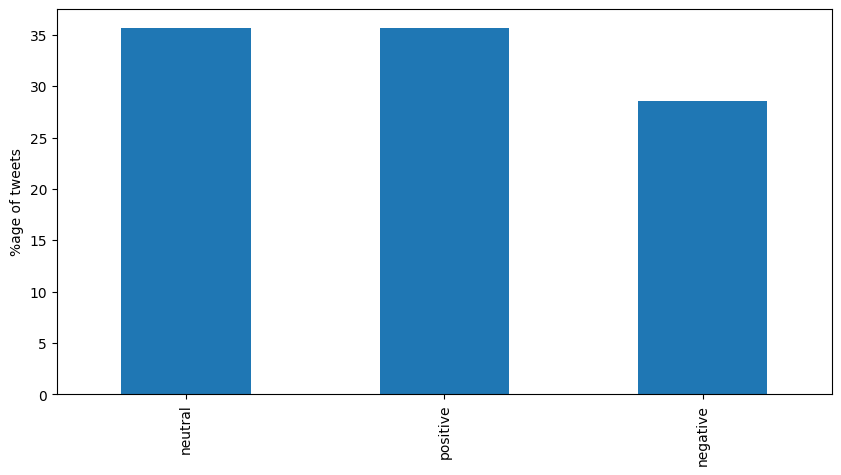

In [ ]:
# Plot graph for analysis of Trump Tweets
plt.figure(figsize=(10,5)) 
(Trump_Tweets.analysis.value_counts(normalize=True)*100).plot.bar()
plt.ylabel("%age of tweets")
plt.show()

**-According to sentiment analysis data for Trump, neutral tweet was obtained with 35.70%, positive tweet with 35.70% and negative tweet with 28.60%.**

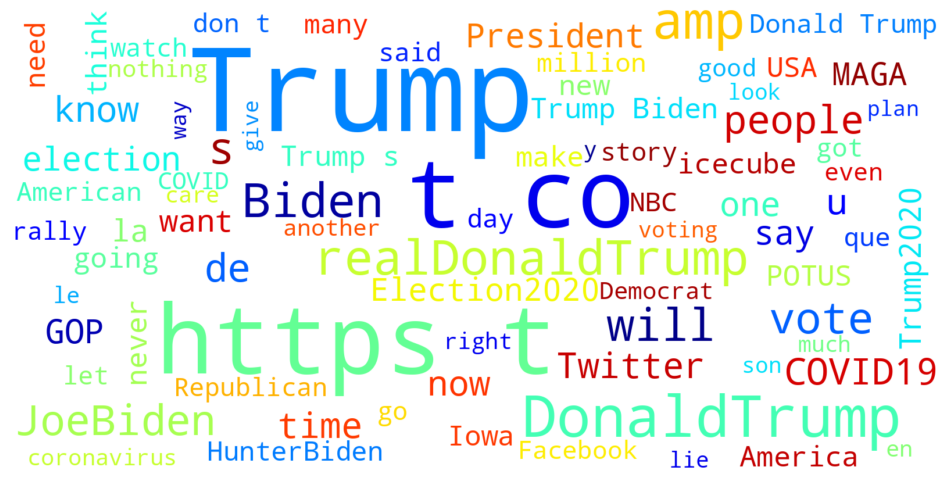

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(trump_df['tweet'][:5000])

In [ ]:
Biden_Tweets = Data_Mixed.query('(Class == "BIDEN")').sort_values('user_followers_count',ascending = False).drop_duplicates(['user_name'])[['tweet','country']]
Biden_Tweets = Biden_Tweets.dropna().loc[Biden_Tweets.country == 'US']


Biden_Tweets.reset_index(inplace = True, drop = True)

Biden_Tweets['ClearTweet'] = Biden_Tweets['tweet'].apply(clean)

 
Biden_Tweets['subjectivity']= Biden_Tweets['ClearTweet'].apply(getSubjectivity)
Biden_Tweets['polarity']    = Biden_Tweets['ClearTweet'].apply(getPolarity)
Biden_Tweets['analysis']    = Biden_Tweets['polarity'].apply(getAnalysis)
Biden_Tweets.head()


Biden_Tweets.head()

,tweet,country,ClearTweet,subjectivity,polarity,analysis
0,judicial watch announced that it has filed its...,US,judicial watch announced that it has filed its...,0.277778,0.166667,positive
1,biden necesita ganar michigan para proclamarse...,US,biden necesita ganar michigan para proclamarse...,0.000000,0.000000,neutral
2,lmao us election section of twitter hunte...,US,lmao us election section of twitter hunte...,0.525000,0.200000,positive
3,twitter won t let you post the nypost link on ...,US,twitter won t let you post the nypost link on ...,0.644444,0.350000,positive
4,talk about falling into a ukrainian hole ...,US,talk about falling into a ukrainian hole ...,0.700000,0.366667,positive


In [ ]:
Biden_Tweets.analysis.value_counts(normalize=True)*100

neutral     45.335821
positive    35.261194
negative    19.402985
Name: analysis, dtype: float64

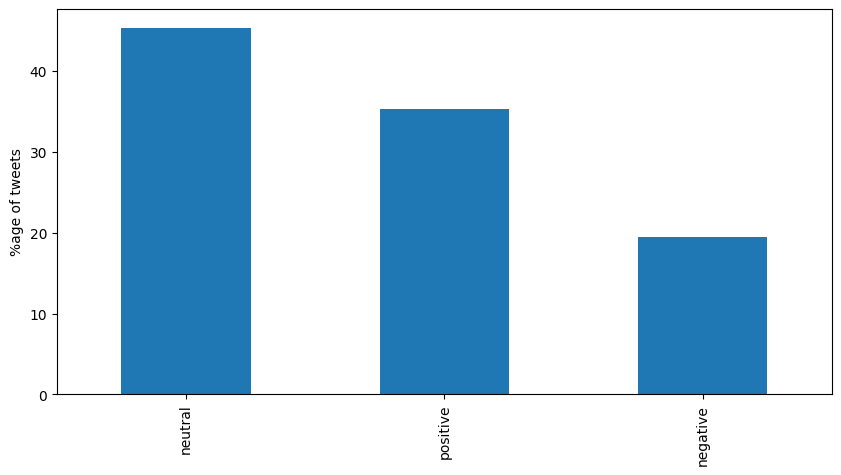

In [ ]:
# Plot graph for analysis of Biden Tweets
plt.figure(figsize=(10,5)) 
(Biden_Tweets.analysis.value_counts(normalize=True)*100).plot.bar()
plt.ylabel("%age of tweets")
plt.show()

**-According to sentiment analysis data for Biden, it is seen that there is neutral tweet with a rate of 45.34%, positive tweet with a rate of 35.26% and negative tweet with a rate of 19.40%.**

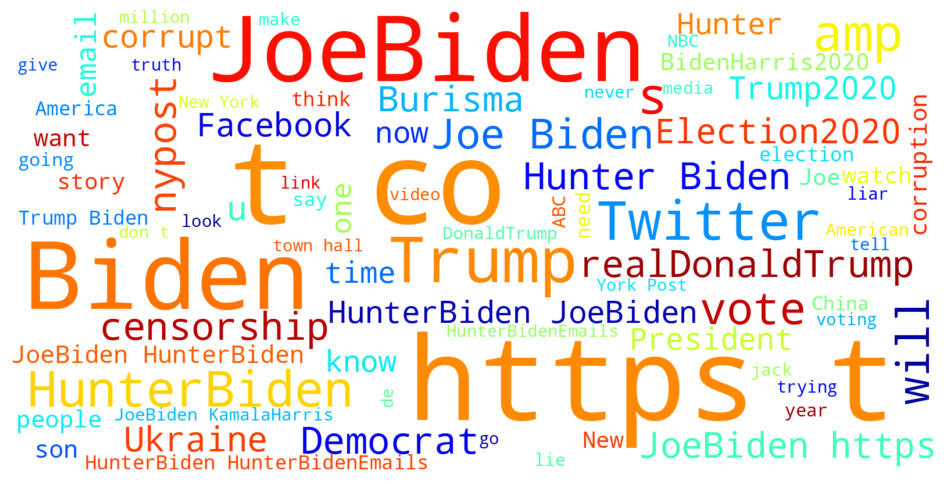

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([str(text) for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(biden_df['tweet'][0:5000])

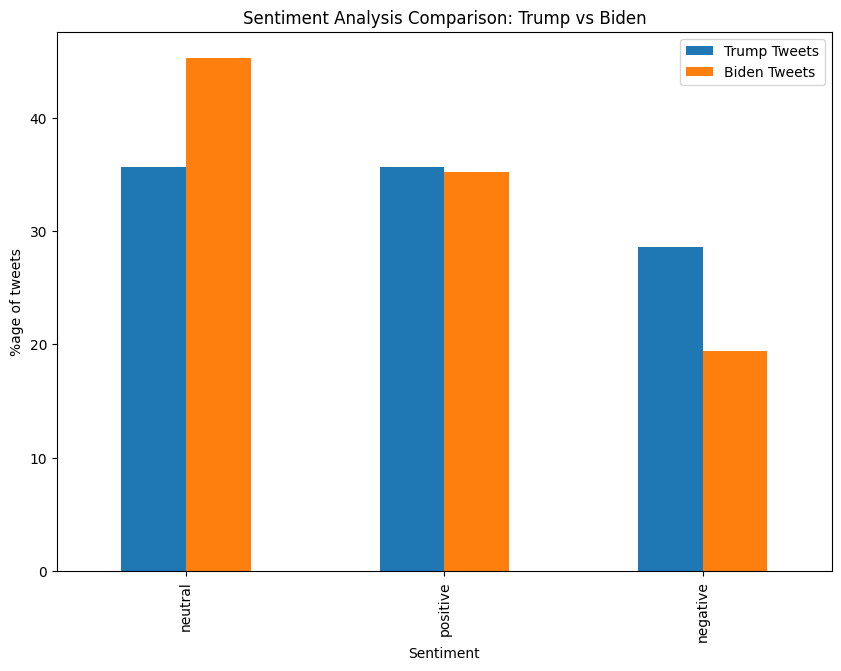

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Biden ve Trump için sentiment analizi sonuçlarından oluşan DataFrame oluşturma
biden_sentiment = Biden_Tweets['analysis'].value_counts(normalize=True) * 100
trump_sentiment = Trump_Tweets['analysis'].value_counts(normalize=True) * 100

# Karşılaştırma için yeni bir DataFrame oluşturma
overall_sent = pd.DataFrame({
    'Trump Tweets': trump_sentiment,
    'Biden Tweets': biden_sentiment
})

# Grafik oluşturma
overall_sent.plot(kind='bar', figsize=(10, 7))
plt.title('Sentiment Analysis Comparison: Trump vs Biden')
plt.xlabel('Sentiment')
plt.ylabel('%age of tweets')
plt.show()

**-Based on these data, it can be concluded that the neutrality rate for Biden is slightly higher than for Trump, but positive and negative tweet for both politicians shows a similar distribution.**

In [ ]:
X = Data_Mixed["tweet"]
y = Data_Mixed["Class"]

#Metin verilerini vektörlere dönüştürme
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

#Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

#K-NN sınıflandırma modelini eğitme
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

#Yeni veri örneği
new_tweet = "I hate Trump"

# Duygusal analizi yapma
blob = TextBlob(new_tweet)
sentiment = blob.sentiment.polarity

#Yeni veriyi vektöre dönüştürme
new_tweet_vectorized = vectorizer.transform([new_tweet])

#Yeni veriyi kullanarak tahmin yapma
prediction = knn_model.predict(new_tweet_vectorized)

# Tahmin sonucunu çıktı olarak yazdırma
if sentiment > 0:
    if prediction[0] == "BIDEN":
        print("Predicted Class: Biden")
    elif prediction[0] == "TRUMP":
        print("Predicted Class: Trump")
elif sentiment < 0:
    if prediction[0] == "TRUMP":
        print("Predicted Class: BIDEN")
    elif prediction[0] == "BIDEN":
        print("Predicted Class: TRUMP")
else:
    print("Predicted Class:", prediction[0])


Predicted Class: BIDEN
